# On neural integragors for ordinary differential equations

Runge-Kutta methods focus on a family of initial value problems.

$y'=f(t,y), \quad y(t_0)=y_0$

Runge-Kutta methods don't care about details of the right-hand side $f$, so it can be as generic as possible, e.g. scalar/vector, time homogeneous/inhomogeneous, etc.

In our implementation, we hope to keep this feature. Any function can be passed to the neural integrator as its argument.

In [1]:
using Flux, Solaris, OrdinaryDiffEq, Plots, Solaris.DiffEqFlux, Test
Plots.pyplot()

Plots.PyPlotBackend()

Let's consider the scalar equation first.

simple one:

$f = -e^{-t} \rightarrow y=e^{-t}+C$

complex one:

$f = -ye^{-t}$

In [2]:
f(y, t) = -exp(-t) * y
f(y, p, t) = -exp(-t) * y # parameterized equation for DifferentialEquations.jl

f (generic function with 2 methods)

## Data generation

We define the computational parameters.

In [3]:
h = 0.1 # time step

0.1

Then we prepare the dataset.
It can be produced following theoretical solution (if it exists) or by numerical solver.

In [4]:
X = randn(Float32, 1, 1000)
T = rand(Float32, 1, 1000) * 50

Y = zeros(Float32, 1, 1000)
for i in axes(X, 2)
    u0 = X[1, i]
    t0 = T[1, i]
    C = u0 - exp(-t0)
    Y[1, i] = exp(-(t0+h)) + C
end

Y1 = zeros(Float32, 1, 1000)
for i in axes(X, 2)
    u0 = X[1, i]
    tspan = (T[1, i], T[1, i] + h)
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob, Tsit5(), dt = h, adaptive=false)
    Y1[1, i] = sol.u[end]
end

@show Y1 ≈ Y # the two results shoud be equivalent in the sense of numerical error
Y .= Y1

Y1 ≈ Y = false


1×1000 Matrix{Float32}:
 0.859101  0.0787001  -0.159207  -1.3573  …  0.45256  -1.79873  1.94718

## Model architecture

The key is to parameterized the numerical scheme.

We first follow the solution algorithm in a multi-step Runge-Kutta scheme, and define the learnable parameters.

In [5]:
init = :allzero # kutta3

# p[9]
# p[1:3]: a21, a31, a32
# p[4:6]: b
# p[7:9]: c

function init_params(p, init=:allzero)
    eval(init)(p)
end

function allzero(p)
    p .= 0.
end

function kutta3(p)
    a21 = 1/2
    a31 = -1
    a32 = 2
    b1 = 1/6
    b2 = 2/3
    b3 = 1/6
    c1 = 0
    c2 = 1/2
    c3 = 1
    
    p .= Float32[a21, a31, a32, b1, b2, b3, c1, c2, c3] .+ rand(Float32, length(p)) / length(p)
end

kutta3 (generic function with 1 method)

In [6]:
p = Array{Float32}(undef, 9)
init_params(p, init)

9-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [7]:
# our neural RK model
# it's nothing but just parameter flows
function model(p)
    k1 = @. f(X, T)
    k2 = @. f(X + h * p[1] * k1, T + p[8] * h)
    k3 = @. f(X + h * (p[2] * k1 + p[3] * k2), T + p[9] * h)
    
    return @. X + h * (p[4] * k1 + p[5] * k2 + p[6] * k3)
end

function loss(p)
    Y1 = model(p)
    return sum((Y .- Y1).^2) + (sum(p[4:6]) - 1.0)^2 + (p[1] - p[8])^2 + (p[2] + p[3] - p[9])^2 # the parameters should satisfy the constraints
end

loss (generic function with 1 method)

In [8]:
cb = function (p, l)
    display(l)
    return false
end

#1 (generic function with 1 method)

In [9]:
res = sci_train(loss, p, LBFGS(), cb = cb, maxiters = 500)

1.1298588922750263

0.0008293491587262152

0.0008237965901531953

0.0006859666050293742

5.210613111405113e-6

1.9146152809691593e-8

4.102693874244457e-9

4.093563567976078e-9

4.093550281422397e-9

4.093554506002036e-9

4.093555901736566e-9

4.0935573575570704e-9

4.093555186114504e-9

4.093551735243949e-9

4.093548997800268e-9

4.093548997800268e-9

u: 9-element Vector{Float32}:
 0.6398719
 0.4265902
 0.42656717
 0.3325615
 0.33355847
 0.33387735
 0.0
 0.639872
 0.85315746

In [10]:
res.u

9-element Vector{Float32}:
 0.6398719
 0.4265902
 0.42656717
 0.3325615
 0.33355847
 0.33387735
 0.0
 0.639872
 0.85315746

## Test the trained model

In [11]:
function predict(t, x, h, f, p)
    k1 = f(x, t)
    k2 = f(x + h * p[1] * k1, t + p[8] * h)
    k3 = f(x + h * (p[2] * k1 + p[3] * k2), t + p[9] * h)
    
    return @. x + h * (p[4] * k1 + p[5] * k2 + p[6] * k3)
end

predict (generic function with 1 method)

In [12]:
f1(y, t) = -2 * exp(-2 * t)

f1 (generic function with 1 method)

In [13]:
u = zeros(100); u[1] = 1.0
t = zeros(100); t[1] = 0.0
for i = 2:length(u)
    t[i] = t[i-1] + h
    u[i] = predict(t[i-1], u[i-1], h, f1, res.u)
end

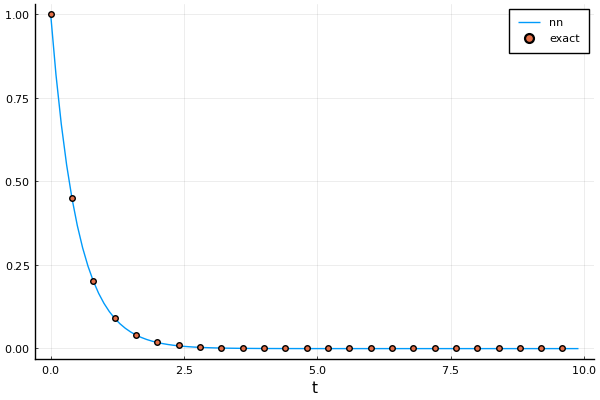

In [14]:
plot(t, u, label="nn", xlabel="t")
scatter!(t[1:4:end], exp.(-2t)[1:4:end], label="exact")

## Future steps?